<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.5 MB 82.2 MB/s 


In [2]:
#https://www.bindingdb.org/bind/chemsearch/marvin/SDFdownload.jsp?download_file=/bind/downloads/BindingDB_All_2022m3.tsv.zip
!wget https://www.bindingdb.org/bind/downloads/BindingDB_All_2022m3.tsv.zip

--2022-04-07 09:41:31--  https://www.bindingdb.org/bind/downloads/BindingDB_All_2022m3.tsv.zip
Resolving www.bindingdb.org (www.bindingdb.org)... 137.110.139.247
Connecting to www.bindingdb.org (www.bindingdb.org)|137.110.139.247|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 417326199 (398M) [application/zip]
Saving to: ‘BindingDB_All_2022m3.tsv.zip’

BindingDB_All_2022m 100%[===================>] 397.99M  1.98MB/s    in 3m 27s  

2022-04-07 09:44:59 (1.93 MB/s) - ‘BindingDB_All_2022m3.tsv.zip’ saved [417326199/417326199]



In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm.auto import tqdm


tqdm.pandas()

In [4]:
COLS = ['Ligand SMILES',
        'Target Source Organism According to Curator or DataSource',
        'Ki (nM)',
        'IC50 (nM)',
        'Kd (nM)',
        'EC50 (nM)',
        'pH',
        'BindingDB Target Chain  Sequence']


NAMES = {'Ligand SMILES': 'smiles',
         'Target Source Organism According to Curator or DataSource': 'target_name',
         'Ki (nM)': 'Ki_nM',
         'IC50 (nM)': 'IC50_nM',
         'Kd (nM)': 'Kd_nM',
         'EC50 (nM)': 'EC50_nM',
         'BindingDB Target Chain  Sequence': 'target'}

In [5]:
data = pd.read_csv("BindingDB_All_2022m3.tsv.zip",
                   compression='zip',
                   sep='\t',
                   usecols=COLS)
data.rename(columns=NAMES, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
data[data.pH.notna()].notna().sum()

smiles         215293
target_name    132724
Ki_nM           38285
IC50_nM        167849
Kd_nM            4037
EC50_nM          7764
pH             215293
target         215004
dtype: int64

In [7]:
data.head(2)

,smiles,target_name,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,target
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,5.5,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,5.5,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...


In [8]:
data.shape

(2407381, 8)

In [9]:
data = data[data['target_name'].str.lower().str.strip().isin(['homo sapiens'])]
data.shape

(1274797, 8)

In [10]:
# functools
def to_non_isomeric_canonical(s):
    """
    Removes isomeric features and makes RDKit canonical.

    Example:
    pubchem_torin1 = "CCC(=O)N1CCN(CC1)C2=C(C=C(C=C2)N3C(=O)C=CC4=CN=C5C=CC(=CC5=C43)C6=CC7=CC=CC=C7N=C6)C(F)(F)F"
    to_non_isomeric_canonical(pubchem_torin1)
    >>CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7ccccc7c6)cc5c43)cc2C(F)(F)F)CC1
    """
    try:
        mol = Chem.MolFromSmiles(s)
        s = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        return s
    except Exception as e:
        # if smiles is invalid return NaN
        return np.nan

In [13]:
def certain_to_float(S):
    
    S = str(S)
    S = S.replace("+", '').replace("-", '')
    S = S.replace(">", "").replace('<', '')
    S = S.replace("E", 'e')

    try:
        F = float(S.strip())
        return F
    except Exception as e:
        print(F, e)
        return np.nan

In [14]:
constants = ['Ki_nM', 'IC50_nM', 'Kd_nM', 'EC50_nM', 'pH']
for col in constants:
    data[col] = data[col].astype('str')
    data[col] = data[col].progress_apply(certain_to_float)

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

In [15]:
data.shape

(1274797, 8)

In [16]:
data = data[data[constants + ['pH']].notna().max(axis=1)]
data.shape

(1273849, 8)

In [18]:
data['smiles'] = data['smiles'].progress_apply(to_non_isomeric_canonical)

  0%|          | 0/1273849 [00:00<?, ?it/s]

In [19]:
data = data[data['smiles'].notna()]
data.shape

(1272888, 8)

In [20]:
data.head()

,smiles,target_name,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,target
142,Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...,Homo sapiens,NaN,50000.0,NaN,NaN,NaN,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...
198,CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)NC(CC(=O)O...,Homo sapiens,90.0,NaN,NaN,NaN,7.4,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...
199,O=CC(CC(=O)O)NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...,Homo sapiens,160.0,NaN,NaN,NaN,7.4,MADKVLKEKRKLFIRSMGEGTINGLLDELLQTRVLNKEEMEKVKRE...
200,O=CC(CC(=O)O)NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...,Homo sapiens,3900.0,NaN,NaN,NaN,7.4,MADKVLKEKRKLFIRSMGEGTINGLLDELLQTRVLNKEEMEKVKRE...
201,CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)NC(CC(=O)O...,Homo sapiens,12000.0,NaN,NaN,NaN,7.4,MADKVLKEKRKLFIRSMGEGTINGLLDELLQTRVLNKEEMEKVKRE...


In [21]:
def is_active(Ki_nM, IC50_nM, Kd_nM, EC50_nM):
    
    for x in [Ki_nM, IC50_nM, Kd_nM, EC50_nM]:
        if (x / 1000) <= 1:
            return 1

    return 0

In [22]:
data["is_active"] = data.progress_apply(
    lambda x: is_active(x.Ki_nM, x.IC50_nM, x.Kd_nM, x.EC50_nM), axis=1)

  0%|          | 0/1272888 [00:00<?, ?it/s]

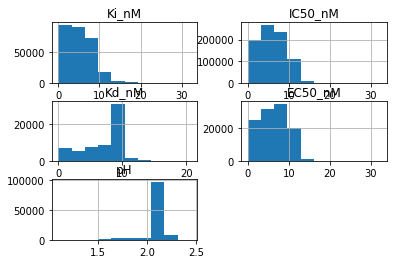

In [23]:
data[constants].apply(np.log1p).hist()

In [24]:
def to_tdc_log(y):
    y = -np.log10(y * 1e-9 + 1e-10)
    if y < 0:
        return np.nan
    return y

In [25]:
def to_mltle_log(y):
    return np.log1p(y)

In [27]:
constants = ['Ki_nM', 'IC50_nM', 'Kd_nM', 'EC50_nM']
for col in constants:
    data['p1' + col.split('_')[0]] = data[col].apply(to_mltle_log)

In [28]:
data.corr()

,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,is_active,p1Ki,p1IC50,p1Kd,p1EC50
Ki_nM,1.000000,0.480270,0.931902,0.668483,0.039393,-0.049001,0.238396,0.136931,0.734668,0.339387
IC50_nM,0.480270,1.000000,0.479908,0.679801,-0.000371,-0.003710,0.119111,0.022363,0.339045,0.245660
Kd_nM,0.931902,0.479908,1.000000,0.970497,0.011839,-0.016694,0.631893,0.429084,0.080584,0.849249
EC50_nM,0.668483,0.679801,0.970497,1.000000,-0.001697,-0.006436,0.241393,0.232767,0.767761,0.042321
pH,0.039393,-0.000371,0.011839,-0.001697,1.000000,0.115543,-0.028699,-0.161683,-0.143633,-0.041305
is_active,-0.049001,-0.003710,-0.016694,-0.006436,0.115543,1.000000,-0.774533,-0.832803,-0.856149,-0.835593
p1Ki,0.238396,0.119111,0.631893,0.241393,-0.028699,-0.774533,1.000000,0.780093,0.982709,0.596956
p1IC50,0.136931,0.022363,0.429084,0.232767,-0.161683,-0.832803,0.780093,1.000000,0.930419,0.623628
p1Kd,0.734668,0.339045,0.080584,0.767761,-0.143633,-0.856149,0.982709,0.930419,1.000000,0.834716
p1EC50,0.339387,0.245660,0.849249,0.042321,-0.041305,-0.835593,0.596956,0.623628,0.834716,1.000000


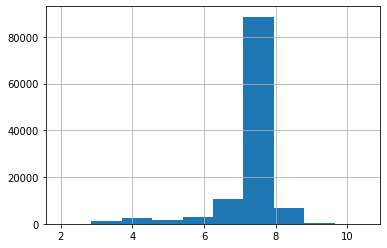

In [29]:
data.pH.hist()

In [30]:
constants = ['p1Ki', 'p1IC50', 'p1Kd', 'p1EC50', 'is_active', 'pH']

In [31]:
data['smiles'] = data['smiles'].str.strip()
data['target'] = data['target'].str.strip().str.upper()
data.head(2)

,smiles,target_name,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,target,is_active,p1Ki,p1IC50,p1Kd,p1EC50
142,Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...,Homo sapiens,NaN,50000.0,NaN,NaN,NaN,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,0,NaN,10.819798,NaN,NaN
198,CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)NC(CC(=O)O...,Homo sapiens,90.0,NaN,NaN,NaN,7.4,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...,1,4.51086,NaN,NaN,NaN


In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
K = []
for i in tqdm(range(1, 100, 2)):
    d = data.groupby(['smiles', 'target'], as_index=False,
                     sort=False).quantile(i / 100)
    d = d[d[constants].notna().max(axis=1)]
    s = d[constants].corr().abs().values.ravel().sum()
    K.append(s)

q = (np.argmax(K) + 1) / 100
print(q) # data co-correlate if aggregating with which quantile?

  0%|          | 0/50 [00:00<?, ?it/s]

0.23


In [34]:
data1 = data.copy()
data = data.groupby(['smiles', 'target'], as_index=False,
                    sort=False).quantile(0.5)
data.shape

(908207, 12)

In [35]:
data = data[data[constants].notna().max(axis=1)]
data.shape

(908207, 12)

In [36]:
data.corr()

,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,is_active,p1Ki,p1IC50,p1Kd,p1EC50
Ki_nM,1.000000,-0.000264,-0.001720,-0.000647,0.019243,-0.039363,0.224347,0.093173,0.044239,0.010414
IC50_nM,-0.000264,1.000000,0.107885,0.043132,0.000875,-0.004008,0.008288,0.025464,0.128448,0.025278
Kd_nM,-0.001720,0.107885,1.000000,0.097618,0.008389,-0.017366,0.045270,0.030708,0.092693,0.140725
EC50_nM,-0.000647,0.043132,0.097618,1.000000,0.015876,-0.004319,0.023735,0.259587,0.253899,0.027561
pH,0.019243,0.000875,0.008389,0.015876,1.000000,0.120474,-0.048628,-0.168278,-0.201695,0.054365
is_active,-0.039363,-0.004008,-0.017366,-0.004319,0.120474,1.000000,-0.774881,-0.838801,-0.844673,-0.832093
p1Ki,0.224347,0.008288,0.045270,0.023735,-0.048628,-0.774881,1.000000,0.802805,0.702821,0.563183
p1IC50,0.093173,0.025464,0.030708,0.259587,-0.168278,-0.838801,0.802805,1.000000,0.777114,0.737645
p1Kd,0.044239,0.128448,0.092693,0.253899,-0.201695,-0.844673,0.702821,0.777114,1.000000,0.659220
p1EC50,0.010414,0.025278,0.140725,0.027561,0.054365,-0.832093,0.563183,0.737645,0.659220,1.000000


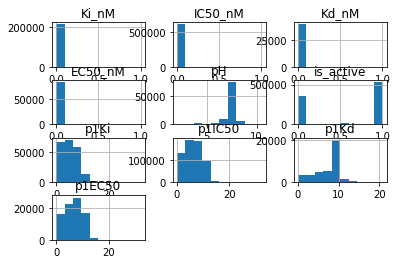

In [37]:
data.hist()

In [49]:
data = data[['smiles', 'target'] + constants]

In [39]:
data['is_active'] = data['is_active'].round()

In [40]:
data['is_active'].value_counts(normalize=True)

1.0    0.583577
0.0    0.416423
Name: is_active, dtype: float64

In [41]:
data.target.str.startswith('M').mean()

0.9976756400247961

In [42]:
data = data[data.target.str.startswith('M')]
data['is_active'].value_counts(normalize=True)

1.0    0.583765
0.0    0.416235
Name: is_active, dtype: float64

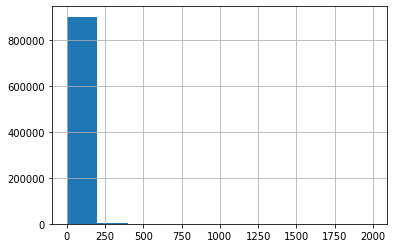

In [43]:
data.smiles.str.len().hist()

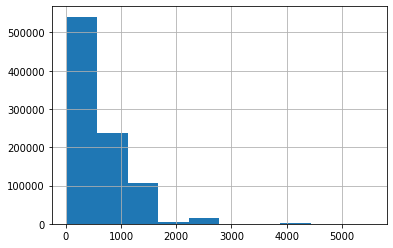

In [44]:
data.target.str.len().hist()

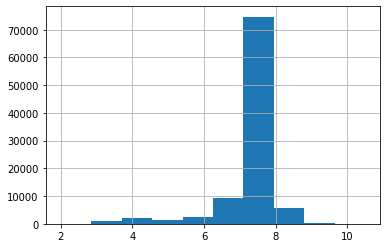

In [45]:
data.pH.hist()

In [51]:
data.tail()

,smiles,target,p1Ki,p1IC50,p1Kd,p1EC50,is_active,pH
908202,COc1cc(C2=CC3=NOCC(c4cc(F)c(F)c(F)c4)N3CCC2)cc...,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,NaN,10.308986,NaN,NaN,0.0,NaN
908203,COc1cc(C=C2CCCN3C2=NOC(c2cc(F)cc(F)c2)C3C)ccc1...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,10.404293,NaN,NaN,0.0,NaN
908204,COc1cc(C=C2CCCN3C2=NOC(c2cc(F)c(F)c(F)c2)C3C)c...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,10.518700,NaN,NaN,0.0,NaN
908205,COc1cc(C2=CC3=NOC(c4cc(F)c(F)c(F)c4)CN3CCC2)cc...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,9.798183,NaN,NaN,0.0,NaN
908206,COc1cc(C2=CC3=NOCC(c4cc(F)c(F)c(F)c4)N3CCC2)cc...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,8.987322,NaN,NaN,0.0,NaN


In [50]:
data.to_csv("data_full_05_pH.zip", index=False, compression='zip')

In [47]:
data['target_len'] = data.target.str.len()
data['target_len_log'] = np.log(data.target.str.len())

data['drug_len'] = data.smiles.str.len()
data['drug_len_log'] = np.log(data.smiles.str.len())

data.corr()

,p1Ki,p1IC50,p1Kd,p1EC50,is_active,pH,target_len,target_len_log,drug_len,dru_len_log
p1Ki,1.000000,0.802678,0.703467,0.563183,-0.765039,-0.047112,-0.083704,-0.088890,-0.123013,-0.217774
p1IC50,0.802678,1.000000,0.777114,0.738030,-0.831824,-0.169115,-0.062227,-0.078074,-0.179384,-0.270512
p1Kd,0.703467,0.777114,1.000000,0.659220,-0.822735,-0.195419,0.070985,0.079004,-0.164152,-0.190937
p1EC50,0.563183,0.738030,0.659220,1.000000,-0.824404,0.054365,0.081309,0.019821,-0.206777,-0.296602
is_active,-0.765039,-0.831824,-0.822735,-0.824404,1.000000,0.121809,0.039535,0.046451,0.128826,0.200072
pH,-0.047112,-0.169115,-0.195419,0.054365,0.121809,1.000000,0.131331,0.130390,-0.044301,-0.048966
target_len,-0.083704,-0.062227,0.070985,0.081309,0.039535,0.131331,1.000000,0.919052,-0.018100,0.013264
target_len_log,-0.088890,-0.078074,0.079004,0.019821,0.046451,0.130390,0.919052,1.000000,-0.018787,0.018104
drug_len,-0.123013,-0.179384,-0.164152,-0.206777,0.128826,-0.044301,-0.018100,-0.018787,1.000000,0.846083
dru_len_log,-0.217774,-0.270512,-0.190937,-0.296602,0.200072,-0.048966,0.013264,0.018104,0.846083,1.000000
